<a href="https://colab.research.google.com/github/lgb201020/AI-python-study/blob/main/%EA%B4%91%EA%B3%A0_%ED%81%B4%EB%A6%AD_%EA%B2%BD%ED%96%A5_%EB%B6%84%EC%84%9D_%EB%AA%A8%EB%8D%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
# *일반적으로 logistic regression은 이진 분류, 대규모 데이터를 다루는데 유리하다.
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from google.colab import drive
drive.mount('/content/gdrive')

MessageError: ignored

In [ ]:
# 훈련 데이터 불러오기
train = "/content/gdrive/MyDrive/Colab Notebooks/train.csv"
train_df = pd.read_csv(train, nrows=100000)
unused_columns, label_column = ["id", "hour", "device_id", "device_ip"], "click"
train_df = train_df.drop(unused_columns, axis=1)
X_dict_train = list(train_df.drop(label_column, axis=1).T.to_dict().values())
y_train = train_df[label_column]

# 테스트 데이터 불러오기
test_df = pd.read_csv(train, skiprows=(1, 100000), nrows=100000)
test_df = test_df.drop(unused_columns, axis=1)
X_dict_test = list(test_df.drop(label_column, axis=1).T.to_dict().values())
y_test = test_df[label_column]

In [ ]:
#불러온 훈련 데이터와 테스트 데이터 확인
X_dict_train[0]

y_train.head()

X_dict_test[0]

y_test.head()

0    0
1    0
2    0
3    0
4    0
Name: click, dtype: int64

In [ ]:
# 불러온 데이터 벡터화로 특징을 수치화하기
vectorizer = DictVectorizer(sparse=True)
"""
** DictVectorizer(sparse=True)는 sparse=True로 설정하는 것은 옵션이 아닌 필!수!이다.
"""
X_train = vectorizer.fit_transform(X_dict_train)
X_test = vectorizer.transform(X_dict_test)

In [ ]:
X_train

<100000x4952 sparse matrix of type '<class 'numpy.float64'>'
	with 1900000 stored elements in Compressed Sparse Row format>

In [ ]:
# logistic regression model object 생성
clf = LogisticRegression(intercept_scaling=10000.0, max_iter=1000, solver = "saga")
# *LogisticRegression()은 C와 penalty를 parameters로 갖고 있다. C는 L1,L2 규제 강도를 지정하는 매개변수로 C가 0에 가까울 수록 규제 강도가 강해진다.
# *penalty는 L1,L2 중 어떠한 규제 알고리즘을 사용할지 지정하는 매개변수이다.
# *L1는 계수값이 항상 0보다 크거나 같다, L2는 계수값이 항상 0보다 크다. 이 둘의 차이는 L1만 계수값이 0이 될 수 있다는 것이다.
# *L1, L2에서 패널티는 overfitting을 방지하고자 사용한다.
clf.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(intercept_scaling=10000.0, max_iter=1000, solver='saga')

In [ ]:
# grid search로 최적의 모델 찾기
parameters = {
    "C": [0.001, 0.01, 0.1, 1, 10],
    "penalty": ["l1", "l2"]
}
# *hyperparameter에서 solver를 설정 안하면 default로 lbfgs가 설정됨-> l1 panelty가 적용이 안된다.

# 하이퍼 파라미터로 C에 규제 강도를 입력하고 penalty에 L1규제를 적용할지 L2규제를 적용할지 정하기 위해 리스트 형테로 둘다 넣음
grid_search = GridSearchCV(clf, parameters, n_jobs=-1, cv=3, scoring="roc_auc")
grid_search.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


GridSearchCV(cv=3,
             estimator=LogisticRegression(intercept_scaling=10000.0,
                                          max_iter=1000, solver='saga'),
             n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10],
                         'penalty': ['l1', 'l2']},
             scoring='roc_auc')

In [ ]:
grid_search.best_params_

{'C': 0.1, 'penalty': 'l2'}

In [ ]:
grid_search.best_estimator_

LogisticRegression(C=0.1, intercept_scaling=10000.0, max_iter=1000,
                   solver='saga')

In [ ]:
# 최적의 하이퍼 파라미터 출력
clf_best = grid_search.best_estimator_
y_pred = clf_best.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
y_pred_proba = clf_best.predict_proba(X_test)[:, 1]
print("정확도:{}, 예측확률:{}".format(accuracy, y_pred_proba))
# 반응변수는 positive probability를 값으로 갖으며 possitive probability는 예측값의 두변째 열에 있다.

정확도:0.82396, 예측확률:[0.15364909 0.15364042 0.1536251  ... 0.18093746 0.18249596 0.10090721]


(array([0.00000000e+00, 1.21197431e-05, 1.21197431e-05, ...,
       9.99903042e-01, 9.99975761e-01, 1.00000000e+00]), array([0.00000000e+00, 0.00000000e+00, 5.71755289e-05, ...,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00]), array([1.82863132, 0.82863132, 0.82863123, ..., 0.07698952, 0.07698155,
       0.07698141]))


TypeError: ignored

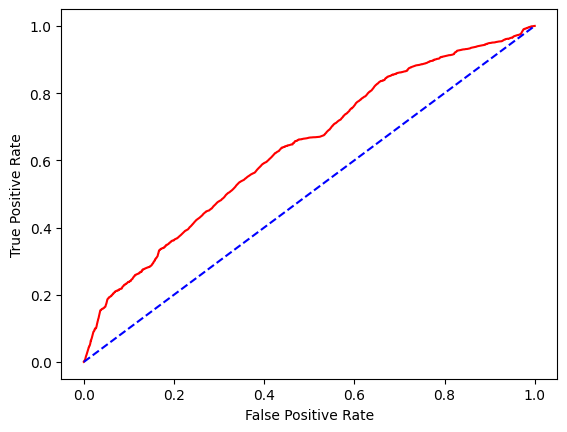

In [ ]:
# 모델 성능 시각화
fpr, tpr, unused_element = roc_curve(y_test, y_pred_proba)
auc = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, "r-", label="Logistic Regression")
plt.plot([0, 1], [0, 1], "b--", label="random guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
print(auc)
plt.title("AUC={0:.2f}".format(auc))
plt.show()

# *Qt 라이브러리가 지금 5.15.6 버전이라 5.15.8 버전이 계속 충돌해서 시각화 모듈이 작동을 안한다. 해결하자! -> 걍 아나콘다 밀고 다시 설치하면 됨
# *from sklearn import preprocessing으로 데이터 최적화하는 것도 고려해볼것
